In [1]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from collections import Counter
import re
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from transformers import AutoModel
from transformers import PreTrainedTokenizer
from transformers import AdamW
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import copy
from rdkit import Chem
from SmilesPE.tokenizer import *
import codecs
from SmilesPE.learner import *
from typing import List, Optional
import os
import collections
from tokenizer_spe import *

In [2]:
df = pd.read_csv('VALID_CAN_SMILES_DATASET.csv')
print(df.shape)
df.head()

(94335, 5)


,E_homo,E_lumo,KS_gap,CAN_SMILES,MW
0,-5.17017,-2.28848,2.88169,C#Cc1[nH]ccc1c1csc2-c3c(C(=O)c12)ccs3,281.352
1,-5.29262,-2.47624,2.81638,O=C1c2c(-c3c1ccs3)scc2c1c2sccc2cc2c1ccs2,380.526
2,-5.30622,-2.40005,2.90617,Cc1sc2-c3sccc3C(=O)c2c1C1=CC(=C)c2c1csc2,338.466
3,-5.99195,-2.91162,3.08033,O=N(=O)c1cc2c(s1)c(sc2C(F)(F)F)c1csc2-c3c(C(=O...,443.463
4,-5.31983,-2.44086,2.87897,Cc1cc2c(-c3c(C2=O)c(cs3)c2cc(ccc2N(=O)=O)c2csc...,409.501


In [3]:
#Character Level Tokenization
def tokenize_smiles_char(smiles):
    return [char for char in smiles]

df['char_level_tokenize'] = df['CAN_SMILES'].apply(tokenize_smiles_char)
all_chars = [char for sublist in df['char_level_tokenize'].tolist() for char in sublist]
char_counts = Counter(all_chars)
print("Total Uniue characters in dataset",len(char_counts))
unique_chars = char_counts.keys()
print(unique_chars)

# Create a character vocabulary and mappings to/from integers
char_to_int = {char: i for i, char in enumerate(unique_chars)}
int_to_char = {i: char for char, i in char_to_int.items()}

def char_encode_smiles(tokenized_smiles):
    return [char_to_int[char] for char in tokenized_smiles]

df['char_level_encoded'] = df['char_level_tokenize'].apply(char_encode_smiles)
df.head()


Total Uniue characters in dataset 36
dict_keys(['C', '#', 'c', '1', '[', 'n', 'H', ']', 's', '2', '-', '3', '(', '=', 'O', ')', 'N', 'F', '4', '/', '\\', 'S', 'o', 'e', 'i', '5', '6', 'B', 'r', 'l', 'P', '+', '\t', '\n', 'G', '@'])


,E_homo,E_lumo,KS_gap,CAN_SMILES,MW,char_level_tokenize,char_level_encoded
0,-5.17017,-2.28848,2.88169,C#Cc1[nH]ccc1c1csc2-c3c(C(=O)c12)ccs3,281.352,"[C, #, C, c, 1, [, n, H, ], c, c, c, 1, c, 1, ...","[0, 1, 0, 2, 3, 4, 5, 6, 7, 2, 2, 2, 3, 2, 3, ..."
1,-5.29262,-2.47624,2.81638,O=C1c2c(-c3c1ccs3)scc2c1c2sccc2cc2c1ccs2,380.526,"[O, =, C, 1, c, 2, c, (, -, c, 3, c, 1, c, c, ...","[14, 13, 0, 3, 2, 9, 2, 12, 10, 2, 11, 2, 3, 2..."
2,-5.30622,-2.40005,2.90617,Cc1sc2-c3sccc3C(=O)c2c1C1=CC(=C)c2c1csc2,338.466,"[C, c, 1, s, c, 2, -, c, 3, s, c, c, c, 3, C, ...","[0, 2, 3, 8, 2, 9, 10, 2, 11, 8, 2, 2, 2, 11, ..."
3,-5.99195,-2.91162,3.08033,O=N(=O)c1cc2c(s1)c(sc2C(F)(F)F)c1csc2-c3c(C(=O...,443.463,"[O, =, N, (, =, O, ), c, 1, c, c, 2, c, (, s, ...","[14, 13, 16, 12, 13, 14, 15, 2, 3, 2, 2, 9, 2,..."
4,-5.31983,-2.44086,2.87897,Cc1cc2c(-c3c(C2=O)c(cs3)c2cc(ccc2N(=O)=O)c2csc...,409.501,"[C, c, 1, c, c, 2, c, (, -, c, 3, c, (, C, 2, ...","[0, 2, 3, 2, 2, 9, 2, 12, 10, 2, 11, 2, 12, 0,..."


In [4]:
#Atomic level tokenization
def atomic_smiles_tokenizer(smi, exclusive_tokens=None):
    """
    Tokenize a SMILES molecule at atom-level:
        (1) 'Br' and 'Cl' are two-character tokens.
        (2) Symbols with brackets are considered as tokens.
        (3) Optionally replace non-exclusive bracketed tokens with '[UNK]'.

    Parameters:
        smi (str): The SMILES string to tokenize.
        exclusive_tokens (list of str, optional): Specific symbols with brackets to keep. 
            All other bracketed symbols are replaced with '[UNK]'. Default is None.

    Returns:
        list of str: The tokenized SMILES.

    Raises:
        AssertionError: If the reconstructed SMILES does not match the original input.
    """
    smi = smi.strip()
    pattern = "(\[[^\]]+\]|Br|Cl|C|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
    regex = re.compile(pattern)
    tokens = regex.findall(smi)

    if exclusive_tokens:
        tokens = [tok if tok in exclusive_tokens or not tok.startswith('[') else '[UNK]' for tok in tokens]

    reconstructed_smi = ''.join(tokens)
    assert smi == reconstructed_smi, f"Tokenization mismatch: {smi} != {reconstructed_smi}"
    return tokens


df['atom_level_tokenize'] = df['CAN_SMILES'].apply(atomic_smiles_tokenizer)
all_atoms = [atom for sublist in df['atom_level_tokenize'].tolist() for atom in sublist]
atom_counts = Counter(all_atoms)
print("Total Unique Atoms in Dataset:", len(atom_counts))
unique_atoms = atom_counts.keys()
print(unique_atoms)

atom_to_int = {atom: i + 1 for i, atom in enumerate(sorted(unique_atoms))}
int_to_atom = {i: atom for atom, i in atom_to_int.items()}

def atomic_encode_smiles(tokenized_smiles):
    return [atom_to_int[atom] for atom in tokenized_smiles if atom!=',']  

# Encode the tokenized SMILES strings
df['atom_level_encoded'] = df['atom_level_tokenize'].apply(atomic_encode_smiles)
df.head()

Total Unique Atoms in Dataset: 50
dict_keys(['C', '#', 'c', '1', '[nH]', 's', '2', '-', '3', '(', '=', 'O', ')', 'N', 'F', '4', '/', '\\', 'S', 'o', 'n', '[se]', '[SiH2]', '5', '6', 'Br', 'Cl', 'P', '[N+]', '[O-]', '[n+]', '[N-]', '[C-]', '[NH-]', '[GeH2]', '[C@@H]', '[C@@]', '[C@H]', '[CH]', '[C]', '[S@]', '[S@@]', '[Se]', '[c]', '[S]', '[CH2]', '[SH]', '[C@]', '[N]', '[n]'])


,E_homo,E_lumo,KS_gap,CAN_SMILES,MW,char_level_tokenize,char_level_encoded,atom_level_tokenize,atom_level_encoded
0,-5.17017,-2.28848,2.88169,C#Cc1[nH]ccc1c1csc2-c3c(C(=O)c12)ccs3,281.352,"[C, #, C, c, 1, [, n, H, ], c, c, c, 1, c, 1, ...","[0, 1, 0, 2, 3, 4, 5, 6, 7, 2, 2, 2, 3, 2, 3, ...","[C, #, C, c, 1, [nH], c, c, c, 1, c, 1, c, s, ...","[14, 1, 14, 47, 6, 43, 47, 47, 47, 6, 47, 6, 4..."
1,-5.29262,-2.47624,2.81638,O=C1c2c(-c3c1ccs3)scc2c1c2sccc2cc2c1ccs2,380.526,"[O, =, C, 1, c, 2, c, (, -, c, 3, c, 1, c, c, ...","[14, 13, 0, 3, 2, 9, 2, 12, 10, 2, 11, 2, 3, 2...","[O, =, C, 1, c, 2, c, (, -, c, 3, c, 1, c, c, ...","[18, 12, 14, 6, 47, 7, 47, 2, 4, 47, 8, 47, 6,..."
2,-5.30622,-2.40005,2.90617,Cc1sc2-c3sccc3C(=O)c2c1C1=CC(=C)c2c1csc2,338.466,"[C, c, 1, s, c, 2, -, c, 3, s, c, c, c, 3, C, ...","[0, 2, 3, 8, 2, 9, 10, 2, 11, 8, 2, 2, 2, 11, ...","[C, c, 1, s, c, 2, -, c, 3, s, c, c, c, 3, C, ...","[14, 47, 6, 50, 47, 7, 4, 47, 8, 50, 47, 47, 4..."
3,-5.99195,-2.91162,3.08033,O=N(=O)c1cc2c(s1)c(sc2C(F)(F)F)c1csc2-c3c(C(=O...,443.463,"[O, =, N, (, =, O, ), c, 1, c, c, 2, c, (, s, ...","[14, 13, 16, 12, 13, 14, 15, 2, 3, 2, 2, 9, 2,...","[O, =, N, (, =, O, ), c, 1, c, c, 2, c, (, s, ...","[18, 12, 17, 2, 12, 18, 3, 47, 6, 47, 47, 7, 4..."
4,-5.31983,-2.44086,2.87897,Cc1cc2c(-c3c(C2=O)c(cs3)c2cc(ccc2N(=O)=O)c2csc...,409.501,"[C, c, 1, c, c, 2, c, (, -, c, 3, c, (, C, 2, ...","[0, 2, 3, 2, 2, 9, 2, 12, 10, 2, 11, 2, 12, 0,...","[C, c, 1, c, c, 2, c, (, -, c, 3, c, (, C, 2, ...","[14, 47, 6, 47, 47, 7, 47, 2, 4, 47, 8, 47, 2,..."


In [5]:
#Data driven Tokenization
#SPE Tokenization
spe_vob= codecs.open('SPE_data.txt')
spe = SPE_Tokenizer(spe_vob)
# some default tokens from huggingface
default_toks = ['[PAD]', 
                '[unused1]', '[unused2]', '[unused3]', '[unused4]','[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', 
                '[UNK]', '[CLS]', '[SEP]', '[MASK]']


# atom-level tokens 
atom_tokens = ['O', '=', 'C', '1', '2', '(', 'S', ')', '3', '4', '[NH]', '#', '5', '6', 'F',
                '[N]', '\\', '/', '[S]', 'N', '[Se]', '[CH2]', '[C]', '[CH]', '[SiH2]', '7', '8', 'Br', 'Cl', 
                '[P]', '[N+]', '[O-]', '[SH]', '9', '%10', '%11', '%12', '[N-]', 'P', ':', '[PH]', '[C-]', '[NH-]',
                'c', 's', 'n', 'o','[se]', '[nH]', '[GeH2]', '[C@@H]', '[C@@]', '[C@H]', '[S@]', '[S@@]', '[c]', '[C@]', '[n]']
# spe tokens
with open('SPE_data.txt', "r") as ins:
    spe_toks = []
    for line in ins:
        spe_toks.append(line.split('\n')[0])

spe_tokens = []
for s in spe_toks:
    spe_tokens.append(''.join(s.split(' ')))
    
spe_vocab = default_toks + atom_tokens + spe_tokens
len(spe_vocab)
with open('vocab_spe.txt', 'w') as f:
    for voc in spe_vocab:
        f.write(f'{voc}\n')
spe_tokenizer = SMILES_SPE_Tokenizer(vocab_file='vocab_spe.txt', spe_file= 'SPE_data.txt')
def spe_encode_smiles(smiles):
    try:
        encoded = spe_tokenizer(smiles)
        return encoded['input_ids']
    except Exception as e:
        print(f"Error encoding SMILES {smiles}: {str(e)}")
        return None
df['data_driven_encoded'] = df['CAN_SMILES'].apply(spe_encode_smiles)

In [6]:
smi_1 = 'CC[N+](C)(C)Cc1ccccc1Br'
smi_2 = 'c1cccc1[invalid]'
encoded_input = spe_tokenizer(smi_1)
spe_tokenizer.decode(encoded_input["input_ids"]) 

'[CLS] CC [N+] (C) (C)C c1ccccc1 Br [SEP]'

In [7]:
df.head()

,E_homo,E_lumo,KS_gap,CAN_SMILES,MW,char_level_tokenize,char_level_encoded,atom_level_tokenize,atom_level_encoded,data_driven_encoded
0,-5.17017,-2.28848,2.88169,C#Cc1[nH]ccc1c1csc2-c3c(C(=O)c12)ccs3,281.352,"[C, #, C, c, 1, [, n, H, ], c, c, c, 1, c, 1, ...","[0, 1, 0, 2, 3, 4, 5, 6, 7, 2, 2, 2, 3, 2, 3, ...","[C, #, C, c, 1, [nH], c, c, c, 1, c, 1, c, s, ...","[14, 1, 14, 47, 6, 43, 47, 47, 47, 6, 47, 6, 4...","[12, 429, 212, 115, 225, 13]"
1,-5.29262,-2.47624,2.81638,O=C1c2c(-c3c1ccs3)scc2c1c2sccc2cc2c1ccs2,380.526,"[O, =, C, 1, c, 2, c, (, -, c, 3, c, 1, c, c, ...","[14, 13, 0, 3, 2, 9, 2, 12, 10, 2, 11, 2, 3, 2...","[O, =, C, 1, c, 2, c, (, -, c, 3, c, 1, c, c, ...","[18, 12, 14, 6, 47, 7, 47, 2, 4, 47, 8, 47, 6,...","[12, 557, 300, 133, 59, 161, 91, 182, 19, 13]"
2,-5.30622,-2.40005,2.90617,Cc1sc2-c3sccc3C(=O)c2c1C1=CC(=C)c2c1csc2,338.466,"[C, c, 1, s, c, 2, -, c, 3, s, c, c, c, 3, C, ...","[0, 2, 3, 8, 2, 9, 10, 2, 11, 8, 2, 2, 2, 11, ...","[C, c, 1, s, c, 2, -, c, 3, s, c, c, c, 3, C, ...","[14, 47, 6, 50, 47, 7, 4, 47, 8, 50, 47, 47, 4...","[12, 17, 420, 185, 289, 82, 393, 13]"
3,-5.99195,-2.91162,3.08033,O=N(=O)c1cc2c(s1)c(sc2C(F)(F)F)c1csc2-c3c(C(=O...,443.463,"[O, =, N, (, =, O, ), c, 1, c, c, 2, c, (, s, ...","[14, 13, 16, 12, 13, 14, 15, 2, 3, 2, 2, 9, 2,...","[O, =, N, (, =, O, ), c, 1, c, c, 2, c, (, s, ...","[18, 12, 17, 2, 12, 18, 3, 47, 6, 47, 47, 7, 4...","[12, 344, 293, 142, 79, 164, 225, 13]"
4,-5.31983,-2.44086,2.87897,Cc1cc2c(-c3c(C2=O)c(cs3)c2cc(ccc2N(=O)=O)c2csc...,409.501,"[C, c, 1, c, c, 2, c, (, -, c, 3, c, (, C, 2, ...","[0, 2, 3, 2, 2, 9, 2, 12, 10, 2, 11, 2, 12, 0,...","[C, c, 1, c, c, 2, c, (, -, c, 3, c, (, C, 2, ...","[14, 47, 6, 47, 47, 7, 47, 2, 4, 47, 8, 47, 2,...","[12, 17, 560, 276, 161, 190, 454, 175, 265, 13]"


In [7]:
class SmilesDataset(Dataset):
    def __init__(self, encodings, properties):
        self.encodings = encodings  
        self.properties = properties  

    def __len__(self):
        return len(self.properties)

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.encodings[idx], dtype=torch.long),
            'attention_mask': torch.tensor([1]*len(self.encodings[idx]), dtype=torch.long)
        }
        item['properties'] = torch.tensor(self.properties[idx], dtype=torch.float)
        return item


# Get the input and output data
char_X = list(df['char_level_encoded'])  
atom_X = list(df['atom_level_encoded'])  
y = df[['E_homo', 'E_lumo']].values  

X_train_char, X_test_char, y_train_char, y_test_char = train_test_split(char_X, y, test_size=0.2, random_state=42)
X_train_atom, X_test_atom, y_train_atom, y_test_atom = train_test_split(atom_X, y, test_size=0.2, random_state=42)

#Normalize properties
scaler = StandardScaler()
char_y_train_scaled = scaler.fit_transform(y_train_char)  
char_y_test_scaled = scaler.transform(y_test_char) 
atom_y_train_scaled = scaler.fit_transform(y_train_atom)  
atom_y_test_scaled = scaler.transform(y_test_atom) 

# Convert the lists of integers to tensors
char_train_encodings = torch.nn.utils.rnn.pad_sequence([torch.tensor(seq) for seq in X_train_char], batch_first=True)
char_test_encodings = torch.nn.utils.rnn.pad_sequence([torch.tensor(seq) for seq in X_test_char], batch_first=True)
atom_train_encodings = torch.nn.utils.rnn.pad_sequence([torch.tensor(seq) for seq in X_train_atom], batch_first=True)
atom_test_encodings = torch.nn.utils.rnn.pad_sequence([torch.tensor(seq) for seq in X_test_atom], batch_first=True)

# Create datasets
char_train_dataset = SmilesDataset(char_train_encodings, char_y_train_scaled)
char_test_dataset = SmilesDataset(char_test_encodings, char_y_test_scaled)
atom_train_dataset = SmilesDataset(atom_train_encodings, atom_y_train_scaled)
atom_test_dataset = SmilesDataset(atom_test_encodings, atom_y_test_scaled)

# Create data loaders
char_train_loader = DataLoader(char_train_dataset, batch_size=32, shuffle=True)
char_test_loader = DataLoader(char_test_dataset, batch_size=32, shuffle=True)
atom_train_loader = DataLoader(atom_train_dataset, batch_size=32, shuffle=True)
atom_test_loader = DataLoader(atom_test_dataset, batch_size=32, shuffle=True)

In [8]:
class ChemBERTaForPropertyPrediction(torch.nn.Module):
    def __init__(self, model_checkpoint, num_properties):
        super().__init__()
        self.chemberta = AutoModel.from_pretrained(model_checkpoint)
        self.regressor = torch.nn.Linear(self.chemberta.config.hidden_size, num_properties)

    def forward(self, input_ids, attention_mask):
        outputs = self.chemberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.regressor(pooled_output)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
char_model = ChemBERTaForPropertyPrediction('seyonec/ChemBERTa-zinc-base-v1', num_properties=2).to(device)
atom_model = ChemBERTaForPropertyPrediction('seyonec/ChemBERTa-zinc-base-v1', num_properties=2).to(device)
char_optimizer = AdamW(char_model.parameters(), lr=1e-4)
atom_optimizer = AdamW(atom_model.parameters(), lr=1e-4)

C:\Users\akepa\anaconda3\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
def train(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, properties = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['properties'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = torch.nn.functional.mse_loss(outputs, properties)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, properties = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['properties'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = torch.nn.functional.mse_loss(outputs, properties)
            total_loss += loss.item()
    return total_loss / len(data_loader)

In [11]:
num_epochs = 10
char_train_losses = []
char_val_losses = []
for epoch in range(num_epochs):
    char_train_loss = train(char_model, char_train_loader,char_optimizer,device)
    char_val_loss = evaluate(char_model, char_test_loader,device)
    char_train_losses.append(char_train_loss)
    char_val_losses.append(char_val_loss)
    print(f"Epoch {epoch}, Train loss: {char_train_loss}, Validation loss: {char_val_loss}")

C:\Users\akepa\AppData\Local\Temp\ipykernel_31456\3783222535.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.encodings[idx], dtype=torch.long),


Epoch 0, Train loss: 0.31577857838957024, Validation loss: 0.21884229044287892
Epoch 1, Train loss: 0.19371076761703462, Validation loss: 0.2148197685131582
Epoch 2, Train loss: 0.1685873592251082, Validation loss: 0.15109347759161965
Epoch 3, Train loss: 0.15106819375667244, Validation loss: 0.15670955969115435
Epoch 4, Train loss: 0.14193866695954468, Validation loss: 0.14775119447859666
Epoch 5, Train loss: 0.1315363417630253, Validation loss: 0.13904555548550718
Epoch 6, Train loss: 0.12452586020622126, Validation loss: 0.13358144203232505
Epoch 7, Train loss: 0.11839039386228364, Validation loss: 0.12117539519223117
Epoch 8, Train loss: 0.11446977683886626, Validation loss: 0.11961177550256252
Epoch 9, Train loss: 0.11054423476216803, Validation loss: 0.1193856801143137


In [13]:
torch.save({
            'model_state_dict': char_model.state_dict(),
            'optimizer_state_dict': char_optimizer.state_dict(),
            }, 'ChemBERTa_char_Level.pth')


In [14]:
def evaluate_and_save(model, data_loader, scaler, device, filename):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            properties = batch['properties'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions.append(outputs.cpu().numpy())
            actuals.append(properties.cpu().numpy())
    
    # Concatenate all batches
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    
    # Inverse transform of the scaled properties
    y_pred = scaler.inverse_transform(predictions)
    y_actual = scaler.inverse_transform(actuals)
    
    # Calculate metrics
    mse = mean_squared_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)
    
    # Save test predictions and actual values to CSV
    test_results = pd.DataFrame({
        'E_homo_actual': y_actual[:, 0],
        'E_lumo_actual': y_actual[:, 1],
        'E_homo_predicted': y_pred[:, 0],
        'E_lumo_predicted': y_pred[:, 1]
    })
    test_results.to_csv(filename, index=False)
    
    return (y_actual, y_pred, mse, r2)

char_model.to(device)  # Ensure model is on the correct device
evaluate_and_save(char_model, char_test_loader, scaler, device, 'char_level_chemberta_results.csv')


C:\Users\akepa\AppData\Local\Temp\ipykernel_31456\3783222535.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.encodings[idx], dtype=torch.long),


(array([[-5.22187   , -1.37418   ],
        [-5.66541   , -1.17009   ],
        [-5.63276   ,  0.26666993],
        ...,
        [-5.4314    , -2.37556   ],
        [-5.1782722 , -2.8050585 ],
        [-5.75249   , -2.34834   ]], dtype=float32),
 array([[-5.287489  , -1.5533823 ],
        [-5.6162357 , -0.8835505 ],
        [-6.1402683 ,  0.22277696],
        ...,
        [-5.4010205 , -2.4161475 ],
        [-5.053577  , -2.995049  ],
        [-5.8255243 , -2.3350766 ]], dtype=float32),
 0.06626862,
 0.8816511086215443)

In [15]:
num_epochs = 10
atom_train_losses = []
atom_val_losses = []
for epoch in range(num_epochs):
    atom_train_loss = train(atom_model, atom_train_loader,atom_optimizer,device)
    atom_val_loss = evaluate(atom_model, atom_test_loader,device)
    atom_train_losses.append(atom_train_loss)
    atom_val_losses.append(atom_val_loss)
    print(f"Epoch {epoch}, Train loss: {atom_train_loss}, Validation loss: {atom_val_loss}")

C:\Users\akepa\AppData\Local\Temp\ipykernel_31456\3783222535.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.encodings[idx], dtype=torch.long),


Epoch 0, Train loss: 0.29173103347262774, Validation loss: 0.17770876538450436
Epoch 1, Train loss: 0.17679978306071645, Validation loss: 0.17385946435190863
Epoch 2, Train loss: 0.15236609734376894, Validation loss: 0.13983088393332593
Epoch 3, Train loss: 0.13719687361511804, Validation loss: 0.14031408355902816
Epoch 4, Train loss: 0.12708919441967811, Validation loss: 0.13974302153466112
Epoch 5, Train loss: 0.11838762792819837, Validation loss: 0.13022142514207605
Epoch 6, Train loss: 0.11210566210501675, Validation loss: 0.12132662663520392
Epoch 7, Train loss: 0.10818657876419131, Validation loss: 0.12375665591177294
Epoch 8, Train loss: 0.10385480262070654, Validation loss: 0.11275250419216641
Epoch 9, Train loss: 0.10020885201373965, Validation loss: 0.11331371698465388


In [16]:
torch.save({
            'atom_model_state_dict': atom_model.state_dict(),
            'atom_optimizer_state_dict': atom_optimizer.state_dict(),
            }, 'ChemBERTa_atom_Level.pth')


In [17]:
evaluate_and_save(atom_model, atom_test_loader, scaler, device, 'atom_level_chemberta_results.csv')

C:\Users\akepa\AppData\Local\Temp\ipykernel_31456\3783222535.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.encodings[idx], dtype=torch.long),


(array([[-5.83412   , -2.58508   ],
        [-5.91032   , -2.04086   ],
        [-4.60961   , -0.54423004],
        ...,
        [-5.86406   , -2.20685   ],
        [-5.56745   , -1.08846   ],
        [-5.64092   , -2.10072   ]], dtype=float32),
 array([[-6.0426593 , -2.8649845 ],
        [-6.0567274 , -2.4310524 ],
        [-4.648237  , -0.59752923],
        ...,
        [-5.7239366 , -2.6406927 ],
        [-5.4152675 , -1.4588449 ],
        [-5.636125  , -1.9047096 ]], dtype=float32),
 0.06284797,
 0.887613138375201)

In [18]:
def plot_results(filename, x_min_homo, x_max_homo, y_min_homo, y_max_homo, x_min_lumo, x_max_lumo, y_min_lumo, y_max_lumo):
    data = pd.read_csv(filename)
    
    # Calculate MSE for HOMO and LUMO
    mse_homo = mean_squared_error(data['E_homo_actual'], data['E_homo_predicted'])
    mse_lumo = mean_squared_error(data['E_lumo_actual'], data['E_lumo_predicted'])
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot HOMO predictions
    axs[0].scatter(data['E_homo_actual'], data['E_homo_predicted'], color='blue', label='HOMO')
    axs[0].plot([x_min_homo, x_max_homo], [y_min_homo, y_max_homo], 'k--', lw=2, label='Ideal Line')
    axs[0].set_xlabel('Actual')
    axs[0].set_ylabel('Predicted')
    axs[0].set_title(f'HOMO Prediction\nMSE: {mse_homo:.2f}')
    axs[0].set_xlim(x_min_homo, x_max_homo)
    axs[0].set_ylim(y_min_homo, y_max_homo)
    axs[0].legend()

    # Plot LUMO predictions
    axs[1].scatter(data['E_lumo_actual'], data['E_lumo_predicted'], color='red', label='LUMO')
    axs[1].plot([x_min_lumo, x_max_lumo], [y_min_lumo, y_max_lumo], 'k--', lw=2, label='Ideal Line')
    axs[1].set_xlabel('Actual')
    axs[1].set_ylabel('Predicted')
    axs[1].set_title(f'LUMO Prediction\nMSE: {mse_lumo:.2f}')
    axs[1].set_xlim(x_min_lumo, x_max_lumo)
    axs[1].set_ylim(y_min_lumo, y_max_lumo)
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()


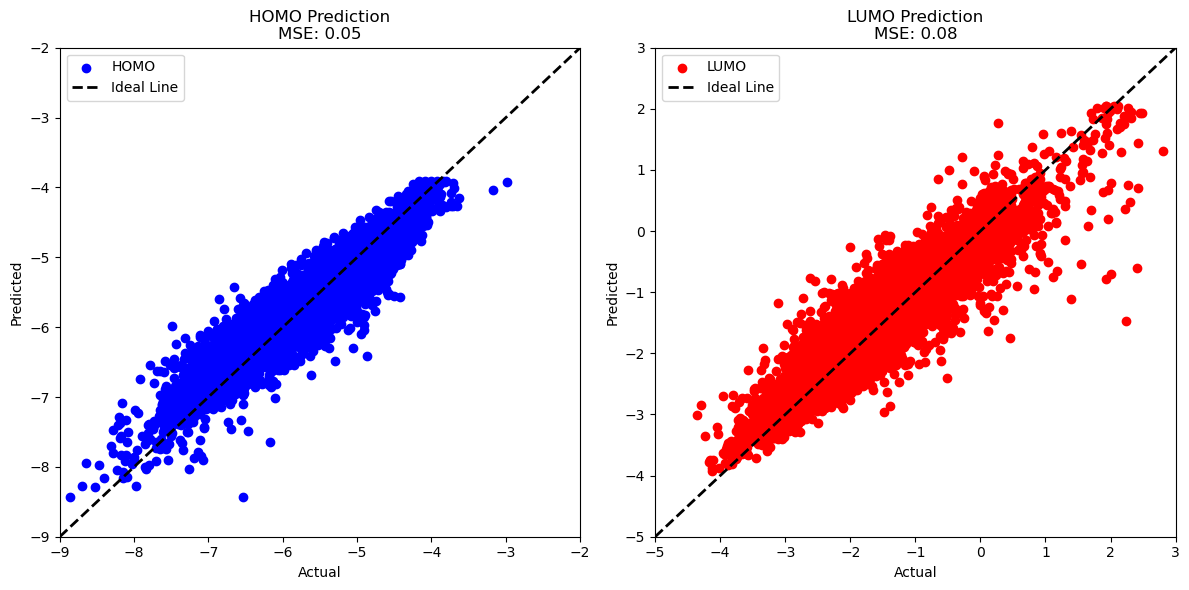

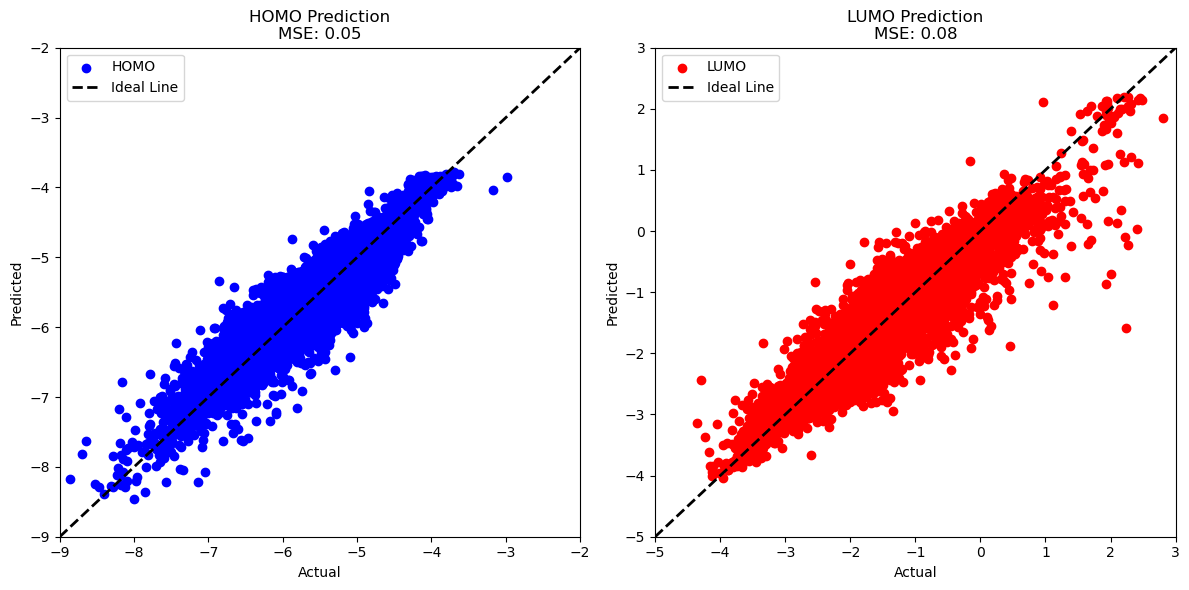

In [19]:
# For Char-Level Predictions
plot_results('char_level_chemberta_results.csv', -9, -2, -9, -2,-5, 3, -5, 3)

plot_results('atom_level_chemberta_results.csv', -9, -2, -9, -2,-5, 3, -5, 3)

